# **Amazon Viral Product Prediction Model**
## **Viral Definition**: SalesRank growth rate < - 30% in 30 days
- Objective Variable: Go_viral(1,0)  

## **Product Category**: Pet Products
## **Data set**: 470K records / 500ASINs(SKUs) / 3 years  
## **Viral Ratio**: 17%
## **Features**: 23 features
## **Topics**:
- **Data Engineering**: JSON manipulation / Data Cleaning / Feature Engineering / One-Hot Encoding / Target-Encoding /  Scaling
- **Machine Learning**: Logistic Regression / XGBoost / Random Forest
  - Techniques: Cross Validation / Grid Search optimization
- **Visualization**: Pearson Correlation Heatmap / SHAP Analysis Summary Plot
- **Evaluation**: Confusion Matrix / Accuracy / Precision / Recall / F1 / AUC / Monetary Calculation  
- **Causal Analysis**: Propensity Score Matching  
- **Model Usability:** Applied prediction to the other category, Baby Product

## **Results:**
- **Accuracy: 0.85 / Precision: 0.86 / AUC: 0.86**
- **High impact features:** SalesRank_RollingAverage / Review_Count / SubCategory(e.g., Cookies, Toys, Toilet Sheets, etc)



## *Condition:
- Product raw data in pkl files extracted from amazon Keepa by API should be stored in your raw_data folder

# Install necessary pkg and libraries

In [ ]:
!pip install imbalanced-learn
!pip install xgboost
!pip install shap

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/150.0 MB 989.2 kB/s eta 0:02:32
   ---------------------------------------- 0.8/150.0 MB 1.2 MB/s eta 0:02:09
   ---------------------------------------- 1.0/150.0 MB 968.5 kB/s eta 0:02:34
   ---------------------------------------- 1.0/150.0 MB 968.5 kB/s eta 0:02:34
   ---------------------------------------- 1.3/150.0 MB 987.4 kB/s eta 0:02:31
   ---------------------------------------- 1.6/150.0 MB 964.5 kB/s eta 0:02:34
    --------------------------------------- 2.1/150.0 MB 1.1 MB/s eta 0:02:11
    --------------------------------------- 2.1/150.0 MB 1.1 MB/s eta 0:02:11
    --------------------------------------- 2.6/150.0 MB 1.1 MB/s eta 0:02:12
    --------------------------------------- 2.9/150.0 MB 1.2 MB/s eta 0:02:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import shap
from scipy import stats
import warnings
from pathlib import Path
import pickle
from datetime import datetime
import pytz
import random
import os
warnings.filterwarnings('ignore')



# Clone from GitHub Repository
- Setting your working directory

In [ ]:
# Clone git repo on Google Colab
!git clone https://github.com/xxxxx

In [ ]:
from pathlib import Path
print(f"Current working directory: {Path.cwd()}")


For Google Colaboratory

In [ ]:
## For gc bucket
import os
os.chdir("c:/Users/xxxx)
#os.chdir("xxxx")
print(f"Changed working directory to: {Path.cwd()}")


For Local

In [ ]:
## For Local
import os
os.chdir("C:/Users/xxxxxxx")
print(f"Changed working directory to: {Path.cwd()}")

# 1 Converting Keepa time to EST datetime

In [ ]:
def keepa_to_est(keepa_time):
    """Convert Keepa time to EST datetime"""
    if isinstance(keepa_time, datetime):
        if keepa_time.tzinfo is None:
            keepa_time = pytz.UTC.localize(keepa_time)
        return keepa_time.astimezone(pytz.timezone('US/Eastern'))

    try:
        unix_time = (keepa_time + 21564000) * 60
        utc_time = datetime.fromtimestamp(unix_time, tz=pytz.UTC)
        return utc_time.astimezone(pytz.timezone('US/Eastern'))
    except TypeError as e:
        print(f"Error converting time: {keepa_time}, type: {type(keepa_time)}")
        raise e

def check_data_completeness(df, required_metrics):
    """
    Check if the data contains all required metrics
    Return (is_complete, missing_metrics)
    """
    existing_columns = set(df.columns)
    required_metrics = set(required_metrics)
    missing_metrics = required_metrics - existing_columns

    # Check if all required columns exist
    if missing_metrics:
        return False, missing_metrics

    # # Check if each column has enough non-null values (e.g., at least 80% of the data)
    # threshold = 0.8
    # for metric in required_metrics:
    #     if df[metric].isna().mean() > (1 - threshold):
    #         missing_metrics.add(f"{metric} (>80% missing)")
    #         return False, missing_metrics

    return True, set()


# 1-2 Product data: Filter Last 3 years
- Get timeseries data and categorical data from AMAZON keepa product raw data JSON file
  - Timeseries: ListPrice / Sales Rank / BUY_BOX_SHIPPING / COUNT_REVIEWS / RATING / COUNT_NEW
  - Categorical Data: itemTypeKeyword / SubCategory / isSNS flag  

- Compress multiple timestamps into a daily level to delete noises
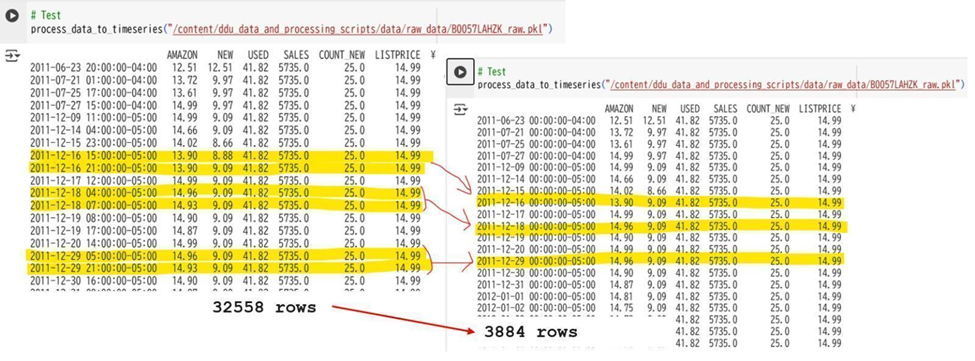

In [ ]:
from datetime import datetime, timedelta
import pytz

def process_data_to_timeseries(file_path):
    """Convert nested data structure to time series DataFrame"""
    required_metrics = {
        'SALES', 'LISTPRICE', 'BUY_BOX_SHIPPING',
        'COUNT_REVIEWS', 'RATING','COUNT_NEW'
    }
    # required_metrics = {
    #     'SALES', 'LISTPRICE', 'BUY_BOX_SHIPPING',
    #     'COUNT_REVIEWS', 'RATING'
    # }

    try:
        with open(file_path, 'rb') as f:
            data = pickle.load(f)

        nested_data = data.get('data', {})
        asin = data.get('asin', 'unknown')

        # Sub Category
        categoryTree = data.get('categoryTree', 'unknown')
        last_category_name = categoryTree[-1].get('name', None) if categoryTree else None

        # ItemTypeKeyword
        TypeKeyword = data.get('itemTypeKeyword','unknown')
        if TypeKeyword:
          TypeKeyword = data.get('itemTypeKeyword',None)
        else:
          TypeKeyword = None

        # isSNS
        isSNS = data.get('isSNS','False')
        if isSNS:
          isSNS = data.get('isSNS','False')
        else:
          isSNS = 'False'

        metrics = {
            'AMAZON': ['AMAZON_time', 'AMAZON'],
            'NEW': ['NEW_time', 'NEW'],
            'USED': ['USED_time', 'USED'],
            'SALES': ['SALES_time', 'SALES'],
            'LISTPRICE': ['LISTPRICE_time', 'LISTPRICE'],
            'NEW_FBA': ['NEW_FBA_time', 'NEW_FBA'],
            'COUNT_NEW': ['COUNT_NEW_time', 'COUNT_NEW'],
            'RATING': ['RATING_time', 'RATING'],
            'COUNT_REVIEWS': ['COUNT_REVIEWS_time', 'COUNT_REVIEWS'],
            'BUY_BOX_SHIPPING': ['BUY_BOX_SHIPPING_time', 'BUY_BOX_SHIPPING']
        }

        time_series_dict = {}
        for metric_name, (time_key, value_key) in metrics.items():
            if time_key in nested_data and value_key in nested_data:
                times = nested_data[time_key]
                values = nested_data[value_key]

                if not isinstance(times, (list, np.ndarray)) or not isinstance(values, (list, np.ndarray)):
                    continue

                for t, v in zip(times, values):
                    try:
                        est_time = keepa_to_est(t)
                        if est_time not in time_series_dict:
                            time_series_dict[est_time] = {}
                        time_series_dict[est_time][metric_name] = np.nan if v == -1 else v
                    except Exception as e:
                        print(f"Error processing {metric_name} for {asin}: {str(e)}")
                        continue

        if not time_series_dict:
            print(f"No valid data found for {asin}")
            return None, asin

        df = pd.DataFrame.from_dict(time_series_dict, orient='index')
        df.sort_index(inplace=True)


        ### 📌 **Compress timestamp into a day**
        df.index = pd.to_datetime(df.index).floor('D')
        df = df.groupby(df.index).max()
        #Check
        # print(f"time_series_dict {df.head(20)}")

###///　Added
        ### 📌 **Fix timezone issue for filtering last 3 years**
        three_years_ago = datetime.now(pytz.UTC) - timedelta(days=3*365)  # 3年前のUTC時間
        three_years_ago = three_years_ago.astimezone(pytz.timezone("US/Eastern"))  # US/Easternに変換
        df = df[df.index >= three_years_ago]  # 3年前より新しいデータのみ保持
        # Check
        # print(f"4years {df.head(20)}")
        # print(f"LISTPRICE {df['LISTPRICE']}")
###///

        ### 📌 **Check data completeness**
        is_complete, missing_metrics = check_data_completeness(df, required_metrics)

####/// Added Skip if all values of LISTPRICE is NaN
        # # `required_metrics` のカラムの中で、すべてのレコードが NaN のものが 1つでもある場合
        # if df[required_metrics].isna().all().any():
        #     print(f"Skipping {asin} because at least one required metric is completely NaN.")
        #     return None, asin

        # すべてのレコードがNaNの `required_metrics` が ある場合スキップ
        if df['LISTPRICE'].isna().all(axis=0).all():
            print(f"Skipping {asin} because all required metrics are NaN.")
            return None, asin
####///

        if not is_complete:
            print(f"Incomplete data for {asin}. Missing metrics: {missing_metrics}")
            return None, asin

        # **Basic data check**
        if len(df) < 60:  # Ensure at least 60 days of data
            print(f"Insufficient data points for {asin}: {len(df)} < 60 days")
            return None, asin

        # NaN の数を表示
        missing_counts = df['LISTPRICE'].isna().sum()
        print(f"NaN counts for {asin}:\n{missing_counts}")

        df = df.ffill().bfill()
        df.fillna(0, inplace=True)  # ListPrice is likely to be all 0 in 3 years
        df['ASIN'] = asin

        #Check
        #print(f"ffill bfill {df}")

        ## **Categorical Variables**
        df['SubCategory'] = last_category_name
        df['TypeKeyword'] = TypeKeyword
        df['TypeKeyword'] = df['TypeKeyword'].astype(str).str.split('-').str[-1]
        df['isSNS'] = isSNS

        #print("最古の日付:", df.index.min())
        #print("最新の日付:", df.index.max())
        print("Record:", df.shape[0])


        return df, asin

    except Exception as e:
        print(f"Error processing file {file_path}: {str(e)}")
        return None, None


In [ ]:
# Test
test = process_data_to_timeseries("C:/Users/skgmo/ddu_data_and_processing_scripts/data/raw_data_baby_product/B00IFWO8PI_raw.pkl")
print(test)
print(test[0].dtypes)

NaN counts for B00IFWO8PI:
1400
Record: 1433
(                           AMAZON   NEW  USED    SALES  COUNT_NEW  \
2021-04-19 00:00:00-04:00    3.99  6.90   0.0  29413.0        4.0   
2021-04-20 00:00:00-04:00    3.99  6.84   0.0  27088.0        5.0   
2021-04-21 00:00:00-04:00    3.99  6.84   0.0  19231.0        4.0   
2021-04-22 00:00:00-04:00    3.99  7.27   0.0  19480.0        5.0   
2021-04-23 00:00:00-04:00    3.99  6.90   0.0  24584.0        5.0   
...                           ...   ...   ...      ...        ...   
2025-04-06 00:00:00-04:00    0.99  0.99   0.0      6.0        2.0   
2025-04-07 00:00:00-04:00    0.99  0.99   0.0      6.0        2.0   
2025-04-08 00:00:00-04:00    0.99  0.99   0.0      6.0        2.0   
2025-04-09 00:00:00-04:00    0.99  0.99   0.0      6.0        2.0   
2025-04-10 00:00:00-04:00    0.99  0.99   0.0      6.0        2.0   

                           BUY_BOX_SHIPPING  NEW_FBA  COUNT_REVIEWS  \
2021-04-19 00:00:00-04:00              6.90     6.99  

# 1-3 Generate features
- Objective variable "Go_viral": 1 if SalesRankChange ratio in 30 days > 30%
- Timeseries:
  - Rolling Average of SalesRank / Price / Reviews
  - Change Ratio in 7 days: Price / Count_Reviews
- Month / Week of Month factors
- External (Temperature: monthly average across 4 cities NY,CA,FL,MO)

In [ ]:
def preprocess_data(df):
    """Apply all preprocessing steps"""
    # Replace inf and -inf with 0
    df = df.replace([np.inf, -np.inf], 0)
    # インデックスのタイムスタンプをカラムとして追加
    df['timestamp'] = df.index

    # Calculate rolling averages
    df['Sales_rank_rolling_7'] = df['SALES'].rolling(window=7, min_periods=1).mean()
    df['Sales_rank_rolling_30'] = df['SALES'].rolling(window=30, min_periods=1).mean()
    df['Sales_rank_rolling_60'] = df['SALES'].rolling(window=60, min_periods=1).mean()
    df['Sales_rank_rolling_90'] = df['SALES'].rolling(window=90, min_periods=1).mean()

    df['List_price_rolling_7'] = df['LISTPRICE'].rolling(window=7, min_periods=1).mean()
    df['List_price_rolling_30'] = df['LISTPRICE'].rolling(window=30, min_periods=1).mean()
    df['Buy_box_price_rolling_7'] = df['BUY_BOX_SHIPPING'].rolling(window=7, min_periods=1).mean()
    df['Buy_box_price_rolling_30'] = df['BUY_BOX_SHIPPING'].rolling(window=30, min_periods=1).mean()

    # Calculate price changes (use clip to avoid -inf)
    df['List_price_change_7'] = df['LISTPRICE'].pct_change(periods=7).clip(-1, 1) * 100
    df['Buy_box_price_change_7'] = df['BUY_BOX_SHIPPING'].pct_change(periods=7).clip(-1, 1) * 100

    # Calculate review metrics
    df['New_reviews'] = df['COUNT_REVIEWS'].diff(periods=7).fillna(0)
    df['Review_growth_rate'] = df['COUNT_REVIEWS'].pct_change().clip(-1, 1) * 100

    # Calculate future metrics
    future_sales_rank = df['SALES'].shift(-30)
    current_sales_rank = df['SALES']
    df['Sales_rank_change_30d'] = ((future_sales_rank - current_sales_rank) / current_sales_rank).clip(-1, 1) * 100
    df['Sales_rank_change_30d'] = df['Sales_rank_change_30d'].fillna(0) # Ensure no NaN values

    # Calculate Go_viral
    df['Go_viral'] = (df['Sales_rank_change_30d'] < -30).astype(int)

    # Check the ratio of Go_viral
    viral_ratio = df['Go_viral'].mean()
    print(f"\nViral ratio for ASIN {df['ASIN'].iloc[0]}: {viral_ratio:.2%}")


    # Save the value of Go_viral
    go_viral_values = df['Go_viral'].copy()

    # If the viral ratio is less than 5%, return None
    if viral_ratio < 0.05:
        print(f"Insufficient viral ratio ({viral_ratio:.2%} < 5%) for ASIN {df['ASIN'].iloc[0]}")
        return None

    # Handle missing values and outliers
    for col in df.columns:
        if col in ['Go_viral', 'ASIN']:
            continue
        if df[col].dtype in ['float64', 'int64']:
            if col.endswith(('_7', '_30', '_60', '_90', '_change_7', '_change_30d')):
                df[col] = df[col].ffill().bfill()
            else:
                q1 = df[col].quantile(0.25)
                q3 = df[col].quantile(0.75)
                iqr = q3 - q1
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                df[col] = df[col].clip(lower_bound, upper_bound)
                df[col] = df[col].fillna(df[col].median())

    # Rename columns for consistency
    df = df.rename(columns={
        'SALES': 'Sales_rank',
        'LISTPRICE': 'List_price',
        'BUY_BOX_SHIPPING': 'Buy_box_price',
        'COUNT_REVIEWS': 'Review_count',
        'RATING': 'Rating'
    })

    # Restore the original value of Go_viral
    df['Go_viral'] = go_viral_values

    # === 🆕 Add Week Category ===
    df['week_of_month'] = ((df.index.day - 1) // 7 + 1).astype(int)  # 1週目〜5週目
    df['week_of_month'] = df['week_of_month'].clip(upper=4)  # 5週目を4週目に統合

    # === 🆕 Add Month Category ===
    df['month'] = df.index.month  # 1月〜12月を取得
    #print(f"month type {type(df['month'][0])}")

    # 月ごとの温度データを辞書として定義
    month_temperature = {
    1: 11.2, 2: 12.3, 3: 16.0, 4: 20.4, 5: 24.3, 6: 26.9,
    7: 29.5, 8: 29.1, 9: 26.8, 10: 22.5, 11: 17.0, 12: 12.3}

# df に temperature カラムを追加
    df['temperature'] = df['month'].map(month_temperature)

    # Print column names
    print(df.columns)

    return df


In [ ]:
# Test: preprocess_data
test_preprocess_data = preprocess_data(test[0])
print(test_preprocess_data.head(3))


Viral ratio for ASIN B00IFWO8PI: 23.03%
Index(['AMAZON', 'NEW', 'USED', 'Sales_rank', 'COUNT_NEW', 'Buy_box_price',
       'NEW_FBA', 'Review_count', 'List_price', 'Rating', 'ASIN',
       'SubCategory', 'TypeKeyword', 'isSNS', 'timestamp',
       'Sales_rank_rolling_7', 'Sales_rank_rolling_30',
       'Sales_rank_rolling_60', 'Sales_rank_rolling_90',
       'List_price_rolling_7', 'List_price_rolling_30',
       'Buy_box_price_rolling_7', 'Buy_box_price_rolling_30',
       'List_price_change_7', 'Buy_box_price_change_7', 'New_reviews',
       'Review_growth_rate', 'Sales_rank_change_30d', 'Go_viral',
       'week_of_month', 'month', 'temperature'],
      dtype='object')
                           AMAZON   NEW  USED  Sales_rank  COUNT_NEW  \
2021-04-19 00:00:00-04:00    3.99  6.90   0.0     29413.0        4.0   
2021-04-20 00:00:00-04:00    3.99  6.84   0.0     27088.0        5.0   
2021-04-21 00:00:00-04:00    3.99  6.84   0.0     19231.0        4.0   

                           Buy

# 2 get_project_path

In [ ]:
def get_project_paths():
    """Get all project-related paths"""
    # Use the current working directory in Jupyter Notebook
    current_dir = Path.cwd()

    # If the current directory is 'src', then the parent directory is the project root
    if current_dir.name == 'src':
       # project_root = current_dir.parent
        project_root = Path.cwd() / "ddu_data_and_processing_scripts"
    else:
        # Otherwise, assume the current directory is the project root
        project_root = current_dir

     # Construct all necessary paths
    paths = {
        'root': project_root,
        'raw_data': project_root / 'data' / 'raw_data_pet_500_202504',
        'processed_data': project_root / 'data' / 'processed_data',
        'results': project_root / 'results'
    }

    # Ensure that the required directories exist
    paths['processed_data'].mkdir(parents=True, exist_ok=True)
    paths['results'].mkdir(parents=True, exist_ok=True)

    # Verify that the raw_data directory exists
    if not paths['raw_data'].exists():
        raise FileNotFoundError(f"Raw data directory not found at {paths['raw_data']}")

    # Print the current path information (for debugging)
    print(f"Current directory: {current_dir}")
    print(f"Project root: {project_root}")
    print(f"Raw data path: {paths['raw_data']}")

    return paths



In [ ]:
get_project_paths()

# 3-0 Import previous processed csv (if you have)
- so you can skip raw data ingestion

In [ ]:
import pandas as pd
#import ace_tools as tools

final_df = pd.read_csv('processed_timeseries_20250417_pet.csv')

# 🎯 1️⃣ CSVファイルを選択してアップロード
#uploaded_file = tools.upload_file()

# if uploaded_file:
#     # 🎯 2️⃣ CSVファイルを `final_df` に読み込む
#     final_df = pd.read_csv(uploaded_file)



# 3 Load data and generate "final_df"
- Load raw product data (*_raw.pkl) files from "raw_data" folder path
- 500ASINs(SKUs)

In [ ]:
# グローバル変数として final_df を定義
final_df = None

def process_final_df():
    """Process raw data files and create global final_df (Only processing, no analysis)"""
    global final_df  # グローバル変数として設定
    try:
        paths = get_project_paths()
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None, None

    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    pkl_files = list(paths['raw_data'].glob('*_raw.pkl'))

    if not pkl_files:
        print(f"No pkl files found in {paths['raw_data']}")
        return None, None

    print(f"Found {len(pkl_files)} pkl files in {paths['raw_data']}")

    successful_files = []
    valid_dfs = []
    processed_asins = set()
    max_attempts = len(pkl_files)
    attempts = 0

    while len(valid_dfs) <= 500 and attempts < max_attempts:
        remaining_files = [f for f in pkl_files if f.stem.split('_')[0] not in processed_asins]
        if not remaining_files:
            break

        file_path = random.choice(remaining_files)
        asin = file_path.stem.split('_')[0]
        processed_asins.add(asin)

        print(f"\nProcessing {file_path.name}...")
        try:
            df, current_asin = process_data_to_timeseries(file_path)
            if df is not None:
                df = preprocess_data(df)
                if df is not None:
                    valid_dfs.append(df)
                    successful_files.append(file_path)
                    print(f"Successfully processed {current_asin}, viral ratio: {df['Go_viral'].mean():.2%}")
                else:
                    print(f"Skipped {asin} due to insufficient viral ratio")
            else:
                print(f"Skipped {asin} due to invalid or incomplete data")
        except Exception as e:
            print(f"Error processing {asin}: {str(e)}")

        attempts += 1
        print(f"Progress: {len(valid_dfs)}/500 valid files found ({attempts}/{max_attempts} attempts)")

    if not valid_dfs:
        print("No valid data files found after processing")
        return None, None

    # 🎯 ここで final_df を作成するだけ！ (分析はしない)
    final_df = pd.concat(valid_dfs, ignore_index=True)  # グローバル変数に保存

    viral_ratio = final_df['Go_viral'].mean()
    print(f"\nViral ratio for final_df: {viral_ratio:.2%}")

    output_path = paths['processed_data'] / f'processed_timeseries_{timestamp}.csv'
    final_df.to_csv(output_path, index=False)
    print(f"\nProcessed data saved to {output_path}")

    print(f"\nNaN columns count:\n{final_df.isnull().sum()}")

    # 🎯 **ここで処理を終える** (分析はしない)
    return timestamp, paths  # global final_df は更新済み

process_final_df()  # データ処理だけ

Current directory: C:\Users\skgmo\ddu_data_and_processing_scripts
Project root: C:\Users\skgmo\ddu_data_and_processing_scripts
Raw data path: C:\Users\skgmo\ddu_data_and_processing_scripts\data\raw_data_pet_500_202504
Found 500 pkl files in C:\Users\skgmo\ddu_data_and_processing_scripts\data\raw_data_pet_500_202504

Processing B0011XOXG2_raw.pkl...
NaN counts for B0011XOXG2:
1431
Record: 1452

Viral ratio for ASIN B0011XOXG2: 17.15%
Index(['AMAZON', 'NEW', 'USED', 'Sales_rank', 'COUNT_NEW', 'List_price',
       'Buy_box_price', 'Review_count', 'NEW_FBA', 'Rating', 'ASIN',
       'SubCategory', 'TypeKeyword', 'isSNS', 'timestamp',
       'Sales_rank_rolling_7', 'Sales_rank_rolling_30',
       'Sales_rank_rolling_60', 'Sales_rank_rolling_90',
       'List_price_rolling_7', 'List_price_rolling_30',
       'Buy_box_price_rolling_7', 'Buy_box_price_rolling_30',
       'List_price_change_7', 'Buy_box_price_change_7', 'New_reviews',
       'Review_growth_rate', 'Sales_rank_change_30d', 'Go_vi

('20250417_234746',
 {'root': WindowsPath('C:/Users/skgmo/ddu_data_and_processing_scripts'),
  'raw_data': WindowsPath('C:/Users/skgmo/ddu_data_and_processing_scripts/data/raw_data_pet_500_202504'),
  'processed_data': WindowsPath('C:/Users/skgmo/ddu_data_and_processing_scripts/data/processed_data'),
  'results': WindowsPath('C:/Users/skgmo/ddu_data_and_processing_scripts/results')})

# Viral trend check
- Top frequence combo among "Go_viral" records: Subcategory & TypeKeyword & Month

In [ ]:
# 🎯 Go_viral = 1 のデータのみ抽出
viral_df = final_df[final_df['Go_viral'] == 1]

# 🎯 Groupして件数・平均を算出
grouped = (
    viral_df
    .groupby(['SubCategory', 'TypeKeyword', 'month'])
    .agg(
        count=('Go_viral', 'size'),
        avg_sales_rank=('Sales_rank', lambda x: round(x.mean())),
        avg_price=('Buy_box_price', lambda x: round(x.mean()))
    )
    .reset_index()
)

# 🎯 Top 5 を件数順に取得
top5_combinations = grouped.sort_values(by='count', ascending=False).head(5).copy()

# 🎯 Go_viral = 1 の総レコード数を計算
total_viral_records = len(viral_df)

# 🎯 パーセンテージ列を追加（%文字列として出力）
top5_combinations['percentage'] = (top5_combinations['count'] / total_viral_records * 100).round(1).astype(str) + '%'
top5_combinations = top5_combinations.drop(columns="count")

# 🎯 表示
print("📊 Top 5 Frequent Combinations (Go_viral = 1) with Avg Sales Rank, Avg Price, and % Share:")
print(top5_combinations)


📊 Top 5 Frequent Combinations (Go_viral = 1) with Avg Sales Rank, Avg Price, and % Share:
    SubCategory TypeKeyword  month  avg_sales_rank  avg_price percentage
418         Dry        food     12            3324         33       2.5%
225      Canned        food     12            5635         25       1.9%
413         Dry        food      7            1815         31       1.5%
224      Canned        food     11            6561         27       1.4%
220      Canned        food      7            8056         23       1.3%


In [ ]:
print(final_df.shape[0])

633994


In [ ]:
#Check
#print(df_updated_scaled.head(2))
#print(df_updated_scaled.columns)
print(f"final_df\n{final_df.columns}")
#print(f"df_updated\n{df_updated.columns}")

final_df
Index(['AMAZON', 'NEW', 'USED', 'Sales_rank', 'List_price', 'COUNT_NEW',
       'Buy_box_price', 'Review_count', 'Rating', 'NEW_FBA', 'ASIN',
       'SubCategory', 'TypeKeyword', 'isSNS', 'Sales_rank_rolling_7',
       'Sales_rank_rolling_30', 'Sales_rank_rolling_60',
       'Sales_rank_rolling_90', 'List_price_rolling_7',
       'List_price_rolling_30', 'Buy_box_price_rolling_7',
       'Buy_box_price_rolling_30', 'List_price_change_7',
       'Buy_box_price_change_7', 'New_reviews', 'Review_growth_rate',
       'Sales_rank_change_30d', 'Go_viral', 'week_of_month', 'month',
       'temperature'],
      dtype='object')


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import pandas as pd
import numpy as np

# 4-2 Feature Engineering pattern2(★Use this)
- Generate df_updated_scaled:
  - Scaling numeric variables
  - Target Encoding: month, week of month: Encoding for categorical variables
  - Month_12: Fixed Effect (To capture Christmas trend)

In [ ]:
def target_encode(df, col_name, target_name, n_splits=5):
    """K-Fold Target Encoding (Avoiding Data Leakage for encoding)"""
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    new_col = col_name + "_encoded"

    df[new_col] = np.nan  # 空の列を作る

    for train_idx, val_idx in kf.split(df):
        train_set, val_set = df.iloc[train_idx], df.iloc[val_idx]
        means = train_set.groupby(col_name)[target_name].mean()
        df.loc[val_idx, new_col] = val_set[col_name].map(means)

    df[new_col] = df[new_col].fillna(df[new_col].mean())  # 欠損値を埋める
    return df

# `final_df` をコピーして新しい `df_updated` を作成
def update_final_df2():
    """Apply preprocessing to final_df and return a new processed dataframe"""
    global df_updated, features  # グローバル変数を明示的に使用

    print("\n=== Starting Final_df Processing ===")

    # `final_df` を変更せず、新しい `df_updated` を作成
    df_updated = final_df.copy()

    ### **1️⃣ SubCategory / TypeKeyword / Month / Week of Month の Target Encoding**
    if 'SubCategory' in df_updated.columns:
        df_updated = target_encode(df_updated, 'SubCategory', 'Go_viral')

    if 'TypeKeyword' in df_updated.columns:
        df_updated = target_encode(df_updated, 'TypeKeyword', 'Go_viral')

    if 'month' in df_updated.columns:
        df_updated = target_encode(df_updated, 'month', 'Go_viral')

    if 'week_of_month' in df_updated.columns:
        df_updated = target_encode(df_updated, 'week_of_month', 'Go_viral')

    ### **2️⃣ isSNS の処理（Boolean変換）**
    df_updated["isSNS"] = df_updated["isSNS"].apply(lambda x: int(str(x).lower() == "true"))

    ### **3️⃣ Month_12 Fixed Effect**
    df_updated['month_12_fixed'] = (df_updated['month'] == 12).astype(int)

    ### **4️⃣ Month_12 × SubCategory の交互作用**
    df_updated['Month_12_SubCategory'] = df_updated['month_12_fixed'] * df_updated['SubCategory_encoded']

    ### **5️⃣ 特徴量リストの生成**
    features = ['Sales_rank', 'List_price', 'Buy_box_price', 'Review_count', 'Rating',
                'Sales_rank_rolling_7', 'Sales_rank_rolling_30', 'Sales_rank_rolling_60',
                'List_price_rolling_7', 'List_price_rolling_30',
                'Buy_box_price_rolling_7', 'Buy_box_price_rolling_30',
                'List_price_change_7', 'Buy_box_price_change_7',
                'New_reviews', 'Review_growth_rate',
                'SubCategory_encoded', 'TypeKeyword_encoded', 'month_encoded', 'week_of_month_encoded',
                'isSNS', 'Month_12_SubCategory','temperature']

    print(f"\nSelected Features: {features}")
    print("\nFinal_df Processing Completed!\n")

    return df_updated  # `df_updated` を返す


# 🎯 `update_final_df()` を実行し、新しい df を作成
df_updated = update_final_df2()

# 🎯 特徴量 & 目的変数
X = df_updated[features]
y = df_updated["Go_viral"]

# 🎯 数値カラムのスケーリング
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # スケール変換

# スケーリング後のデータフレームを作成
df_updated_scaled = pd.DataFrame(X_scaled, columns=features)
df_updated_scaled['Go_viral'] = y.values  # 目的変数を追加

# Add Other columns
# 🎯 `df_updated_scaled` に `features` 以外のカラムを追加
other_columns = [col for col in df_updated.columns if col not in features and col != "Go_viral"]

# 追加するカラムのデータを `df_updated` から取得
df_other = df_updated[other_columns].reset_index(drop=True)

# `df_updated_scaled` に結合
df_updated_scaled = pd.concat([df_updated_scaled, df_other], axis=1)

# 確認
print("\nUpdated DataFrame Overview:")
print(df_updated_scaled.head(2))
print("\nFeature List:", features)
print("\nTarget Distribution:\n", y.value_counts(normalize=True))



=== Starting Final_df Processing ===

Selected Features: ['Sales_rank', 'List_price', 'Buy_box_price', 'Review_count', 'Rating', 'Sales_rank_rolling_7', 'Sales_rank_rolling_30', 'Sales_rank_rolling_60', 'List_price_rolling_7', 'List_price_rolling_30', 'Buy_box_price_rolling_7', 'Buy_box_price_rolling_30', 'List_price_change_7', 'Buy_box_price_change_7', 'New_reviews', 'Review_growth_rate', 'SubCategory_encoded', 'TypeKeyword_encoded', 'month_encoded', 'week_of_month_encoded', 'isSNS', 'Month_12_SubCategory', 'temperature']

Final_df Processing Completed!


Updated DataFrame Overview:
   Sales_rank  List_price  Buy_box_price  Review_count   Rating  \
0   -0.142944    0.784133       0.444683     -0.802992  0.60475   
1   -0.144584    0.784133       0.444683     -0.802799  0.60475   

   Sales_rank_rolling_7  Sales_rank_rolling_30  Sales_rank_rolling_60  \
0             -0.167806              -0.174715              -0.181597   
1             -0.168469              -0.175388              

Execute update_final_df2()

In [ ]:
#Execute
update_final_df2()


=== Starting Final_df Processing ===

Selected Features: ['Sales_rank', 'List_price', 'Buy_box_price', 'Review_count', 'Rating', 'Sales_rank_rolling_7', 'Sales_rank_rolling_30', 'Sales_rank_rolling_60', 'List_price_rolling_7', 'List_price_rolling_30', 'Buy_box_price_rolling_7', 'Buy_box_price_rolling_30', 'List_price_change_7', 'Buy_box_price_change_7', 'New_reviews', 'Review_growth_rate', 'SubCategory_encoded', 'TypeKeyword_encoded', 'month_encoded', 'week_of_month_encoded', 'isSNS', 'Month_12_SubCategory', 'temperature']

Final_df Processing Completed!



,AMAZON,NEW,USED,Sales_rank,List_price,COUNT_NEW,Buy_box_price,Review_count,Rating,NEW_FBA,...,Go_viral,week_of_month,month,temperature,SubCategory_encoded,TypeKeyword_encoded,month_encoded,week_of_month_encoded,month_12_fixed,Month_12_SubCategory
0,15.48,20.74,0.0,263.0,16.57,9.0,15.18,5502.0,4.8,23.75,...,1,3,3,16.0,0.158688,0.167228,0.161109,0.173822,0,0.0
1,15.48,20.74,0.0,228.0,16.57,8.0,15.18,5523.0,4.8,23.75,...,1,3,3,16.0,0.157720,0.167471,0.161804,0.172451,0,0.0
2,15.48,20.74,0.0,259.0,16.57,8.0,15.18,5541.0,4.8,23.75,...,1,3,3,16.0,0.157644,0.166074,0.160291,0.173506,0,0.0
3,15.48,20.74,0.0,270.0,16.57,9.0,15.18,5562.0,4.8,23.75,...,1,3,3,16.0,0.157720,0.167471,0.161804,0.172451,0,0.0
4,15.48,20.74,0.0,270.0,16.57,9.5,15.18,5580.0,4.8,23.75,...,1,3,3,16.0,0.158168,0.166557,0.161456,0.173090,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
473159,14.99,14.99,0.0,153.0,14.99,1.0,14.99,11805.0,4.2,14.99,...,0,1,1,11.2,0.145538,0.126438,0.133706,0.159311,0,0.0
473160,14.99,14.99,0.0,175.0,14.99,1.0,14.99,11813.0,4.2,14.99,...,0,1,1,11.2,0.145251,0.125305,0.133050,0.159000,0,0.0
473161,14.99,14.99,0.0,182.0,14.99,1.0,14.99,11820.0,4.2,14.99,...,0,2,1,11.2,0.145860,0.126502,0.129166,0.178590,0,0.0
473162,14.99,14.99,0.0,188.0,14.99,1.0,14.99,11829.0,4.2,14.99,...,0,2,1,11.2,0.145860,0.126502,0.129166,0.178590,0,0.0


Check the dataset for model training

In [ ]:
#Check
print(df_updated_scaled.head(1))

   Sales_rank  List_price  Buy_box_price  Review_count   Rating  \
0   -0.142944    0.784133       0.444683     -0.802992  0.60475   

   Sales_rank_rolling_7  Sales_rank_rolling_30  Sales_rank_rolling_60  \
0             -0.167806              -0.174715              -0.181597   

   List_price_rolling_7  List_price_rolling_30  ...  NEW_FBA        ASIN  \
0              0.982147               0.981908  ...    34.95  B0011XOXG2   

              SubCategory  TypeKeyword                  timestamp  \
0  Supplements & Vitamins     vitamins  2021-04-19 00:00:00-04:00   

   Sales_rank_rolling_90  Sales_rank_change_30d  week_of_month  month  \
0                  663.0             -22.624434              3      4   

   month_12_fixed  
0               0  

[1 rows x 38 columns]


# ↓ Analysis (Threshold: 0.6)

# 5-1 Analysis 1: Logistic Regression & Correlation Heatmap


🎯 Logistic Regression Model Performance (with Cross Validation):
accuracy: 0.7859
precision: 0.2819
recall: 0.1795
f1: 0.2193
AUC: 0.6170


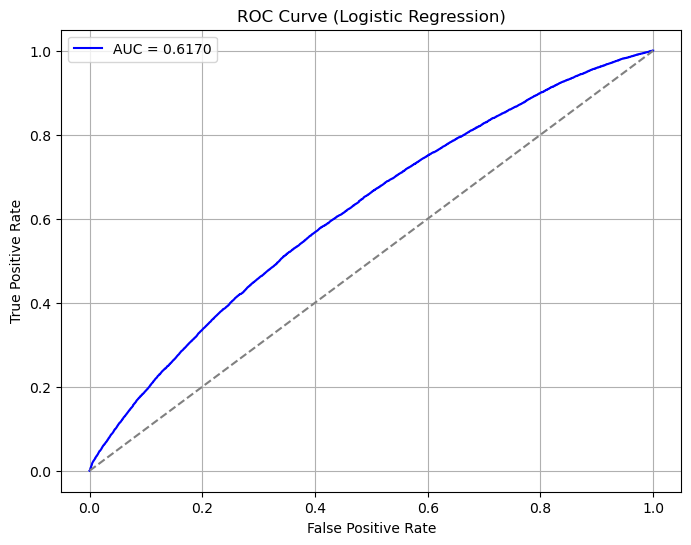

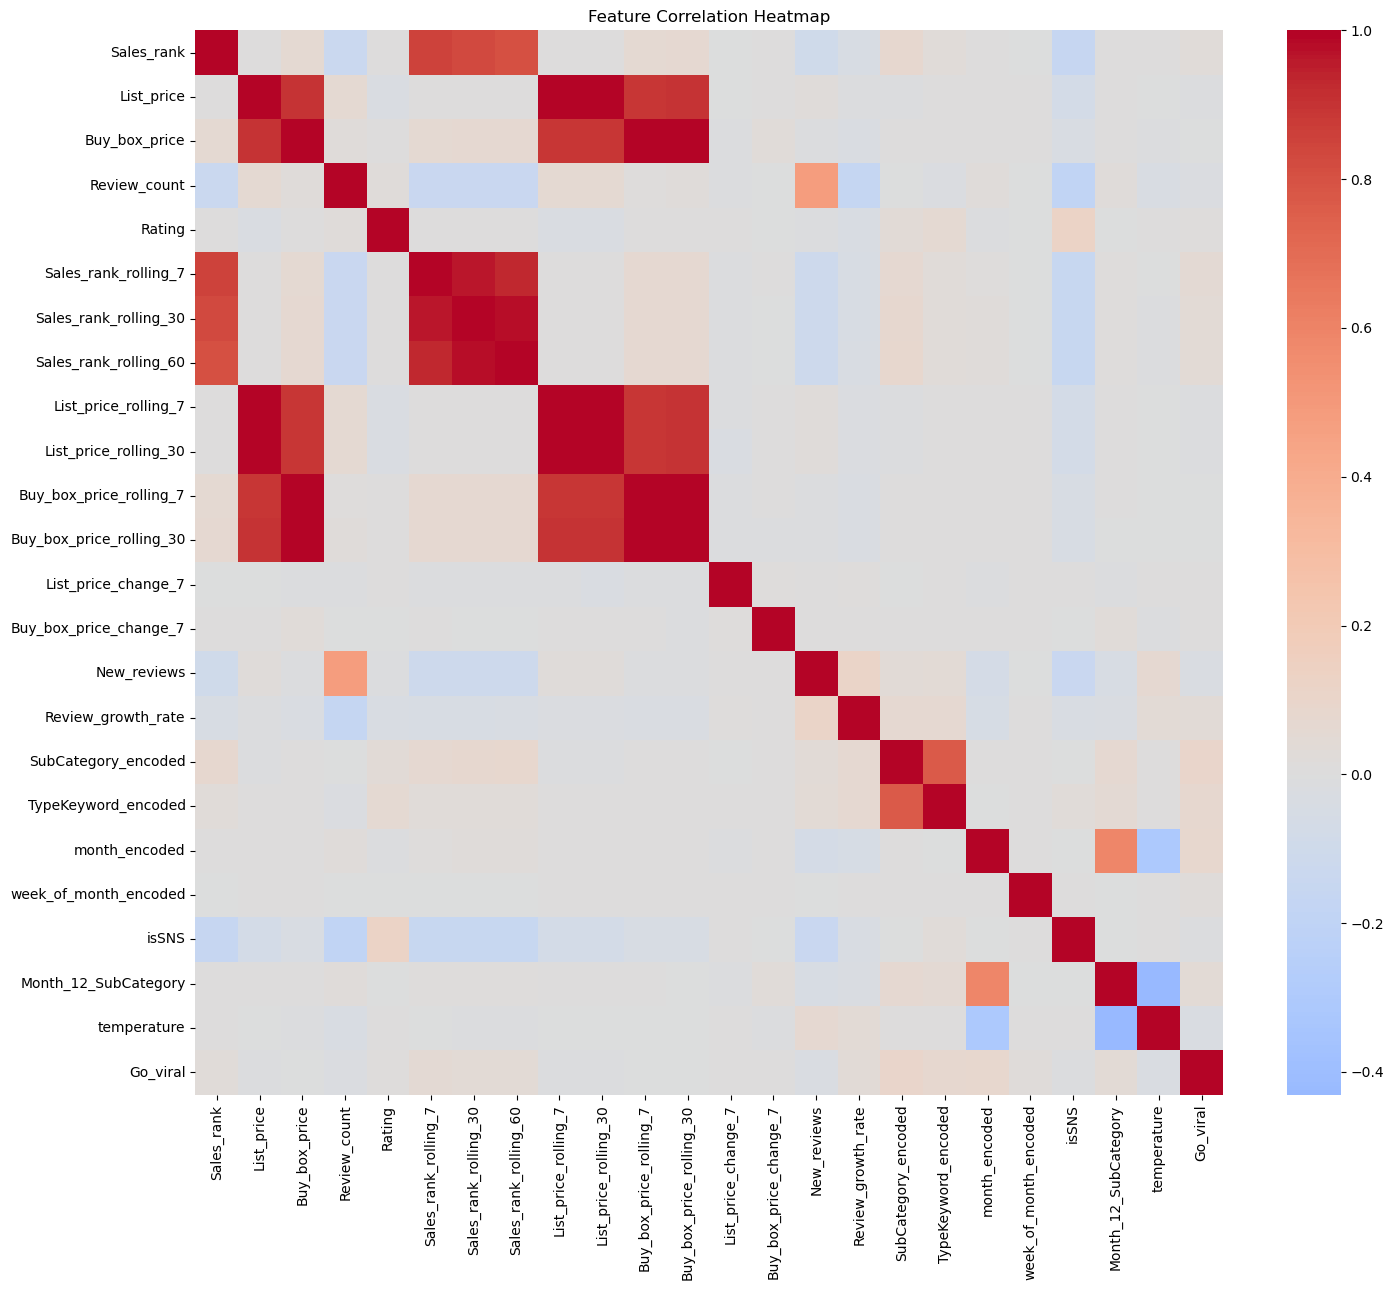

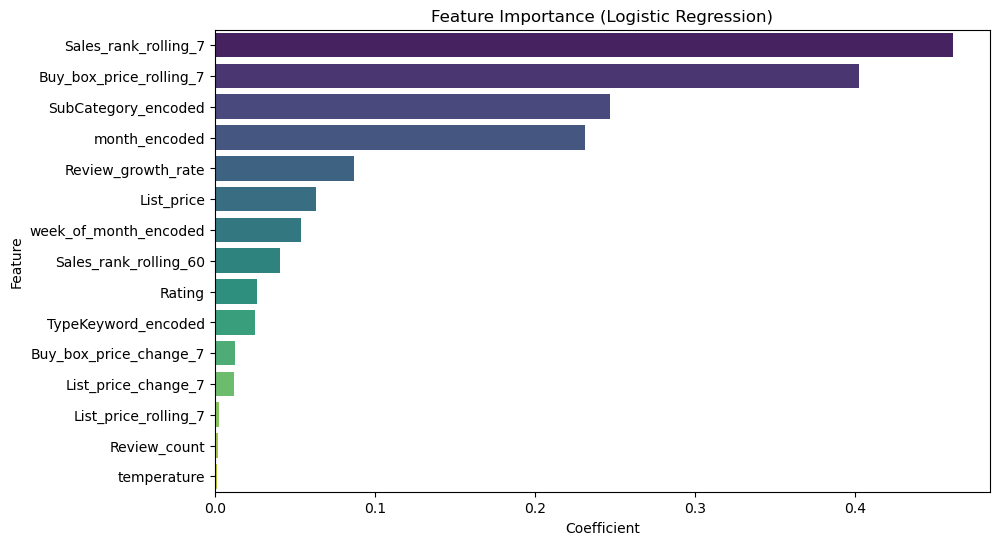


✅ Logistic Regression Model & Correlation Analysis Completed!


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# 🎯 1️⃣ データ準備
global features
X = df_updated_scaled[features]
y = df_updated_scaled["Go_viral"]

# 🎯 2️⃣ 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🎯 3️⃣ クロスバリデーション設定
cv_folds = 5
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# 🎯 4️⃣ Logistic Regression の クロスバリデーション
lr_model = LogisticRegressionCV(
    cv=cv,
    penalty="l2",  # L2正則化
    scoring="roc_auc",
    max_iter=1000,
    random_state=42,
    class_weight="balanced"
)
lr_model.fit(X_train, y_train)

# 🎯 5️⃣ 最適な C を使って Logistic Regression を学習
best_C = lr_model.C_[0]
final_lr_model = LogisticRegression(
    C=best_C,
    penalty="l2",
    max_iter=1000,
    random_state=42,
    class_weight="balanced"
)
final_lr_model.fit(X_train, y_train)

# 🎯 6️⃣ 予測と評価
y_pred_proba = final_lr_model.predict_proba(X_test)[:, 1]  # クラス1の確率
y_pred = (y_pred_proba > 0.6).astype(int)  # 閾値 0.5 で分類

# 評価指標の計算
lr_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred_proba)
}

# 結果表示
print("\n🎯 Logistic Regression Model Performance (with Cross Validation):")
for metric, value in lr_metrics.items():
    print(f"{metric}: {value:.4f}")

# 🎯 7️⃣ AUC曲線をプロット
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {lr_metrics['AUC']:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Logistic Regression)")
plt.legend()
plt.grid()
plt.savefig("lr_auc_curve.png")  # AUCプロットを保存
plt.show()

# 🎯 8️⃣ Correlation Heatmap 作成
#correlation_matrix = df_updated_scaled[features].corr()
correlation_matrix = df_updated_scaled[features + ['Go_viral']].corr()
plt.figure(figsize=(15, 13))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("correlation_heatmap.png")  # ヒートマップを保存
plt.show()

# 🎯 9️⃣ Logistic Regression の 重要度分析
feature_importance = pd.DataFrame(
    {"Feature": features, "Coefficient": final_lr_model.coef_[0]}
).sort_values(by="Coefficient", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x="Coefficient", y="Feature", data=feature_importance[:15], palette="viridis")
plt.title("Feature Importance (Logistic Regression)")
plt.savefig("lr_feature_importance.png")  # 重要度グラフを保存
plt.show()

print("\n✅ Logistic Regression Model & Correlation Analysis Completed!")


# 5-2 Analysis 2: Random Forest
- Cross Validation: K=5


🚀 Starting Random Forest analysis...

✅ Random Forest Metrics:
accuracy: 0.8302
precision: 0.4921
recall: 0.4065
f1: 0.4452
AUC: 0.7863

📊 Feature importance plot saved to rf_feature_importance_20250412_215503.png

📈 AUC-ROC curve saved to rf_auc_roc_curve_20250412_215503.png

📁 Analysis results saved to rf_analysis_results_20250412_215503.csv


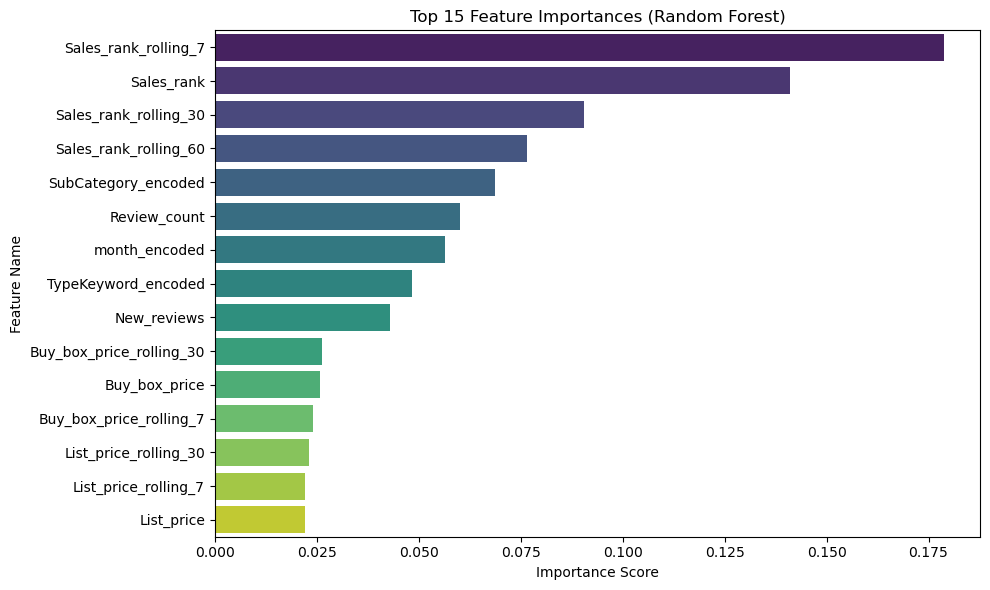

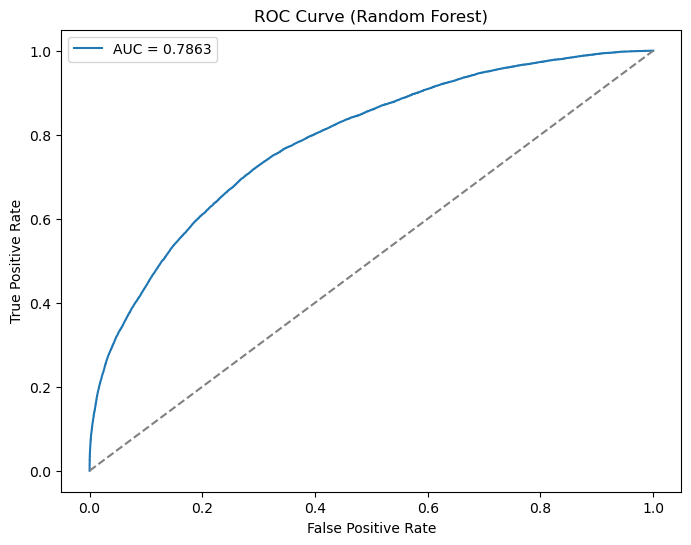

In [ ]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
# import seaborn as sns


def analyze_with_random_forest():
    """Analyze global final_df using Random Forest and save results"""
    global df_updated_scaled, rf_metrics  # グローバル変数を使用

    if df_updated_scaled is None:
        print("⚠️ No valid data for analysis. Please run `process_final_df()` first.")
        return

    print("\n🚀 Starting Random Forest analysis...")

    # 🎯 特徴量 & 目的変数
    #features = [col for col in final_df.columns if col != "Go_viral"]  # "Go_viral" を除く
    global features
    X = df_updated_scaled[features]
    y = df_updated_scaled["Go_viral"]

    # 🎯 訓練データ & テストデータ分割 (80%:20%)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=42
    )

    # 🎯 クロスバリデーション (5-fold)
    cv_folds = 5
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

    # 🎯 Random Forest モデル定義
    rf_model = RandomForestClassifier(
        n_estimators=100,  # 決定木の数
        max_depth=10,  # 最大深さ
        class_weight="balanced",  # クラス不均衡に対応
        random_state=42,
        n_jobs=-1  # 並列処理を有効化
    )

    # 🎯 クロスバリデーションで評価
    cv_auc = cross_val_score(rf_model, X_train, y_train, cv=cv, scoring="roc_auc")

    # 🎯 モデルの学習
    rf_model.fit(X_train, y_train)

    # 🎯 予測
    #y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]  # クラス1 (Go_viral=1) の確率
    y_pred = (y_pred_proba >= 0.6).astype(int)


    # 🎯 評価指標計算
    rf_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_pred_proba),
        #"CV_AUC_mean": np.mean(cv_auc)  # クロスバリデーションの平均AUC
    }

    print("\n✅ Random Forest Metrics:")
    for metric, value in rf_metrics.items():
        print(f"{metric}: {value:.4f}")

    # 🎯 特徴量の重要度プロット
    # `X_train.columns` を使って features を取得
    features = list(X_train.columns)
    feature_importance = pd.DataFrame(
        {"Feature": features, "Importance": rf_model.feature_importances_}
    ).sort_values(by="Importance", ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x="Importance", y="Feature", data=feature_importance[:15], palette="viridis")
    plt.title("Top 15 Feature Importances (Random Forest)")
    plt.xlabel("Importance Score")
    plt.ylabel("Feature Name")
    plt.tight_layout()

    # 🎯 保存
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    feature_imp_path = f"rf_feature_importance_{timestamp}.png"
    plt.savefig(feature_imp_path)
    print(f"\n📊 Feature importance plot saved to {feature_imp_path}")

    # 🎯 AUC-ROC 曲線を描画
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"AUC = {rf_metrics['AUC']:.4f}")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # ランダム予測の基準線
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Random Forest)")
    plt.legend()

    # 🎯 保存
    roc_path = f"rf_auc_roc_curve_{timestamp}.png"
    plt.savefig(roc_path)
    print(f"\n📈 AUC-ROC curve saved to {roc_path}")

    # 🎯 評価結果を保存
    results_path = f"rf_analysis_results_{timestamp}.csv"
    pd.DataFrame([rf_metrics]).to_csv(results_path, index=False)
    print(f"\n📁 Analysis results saved to {results_path}")

    return rf_metrics, rf_model


if __name__ == "__main__":
    analyze_with_random_forest()


# 5-3 Analysis 3: XGBoost: Cross-Validation (5-fold)
- Cross Validation: K = 5


🎯 XGBoost Model Performance (with Cross Validation):
accuracy: 0.8297
precision: 0.5053
recall: 0.5700
f1: 0.5357
AUC: 0.8305


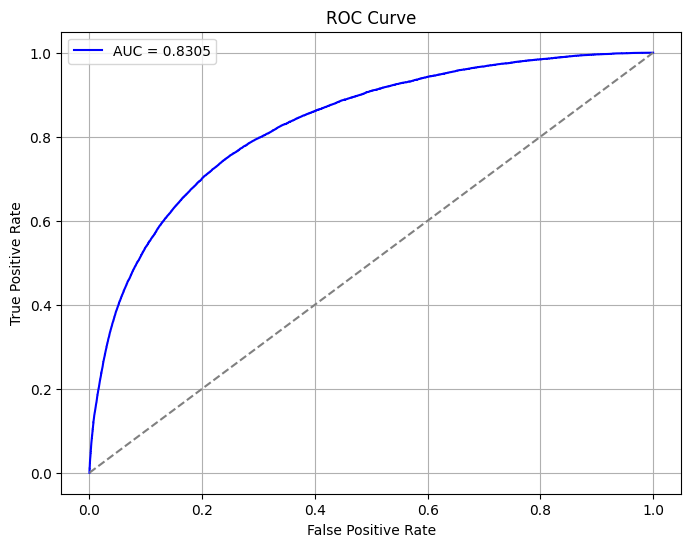

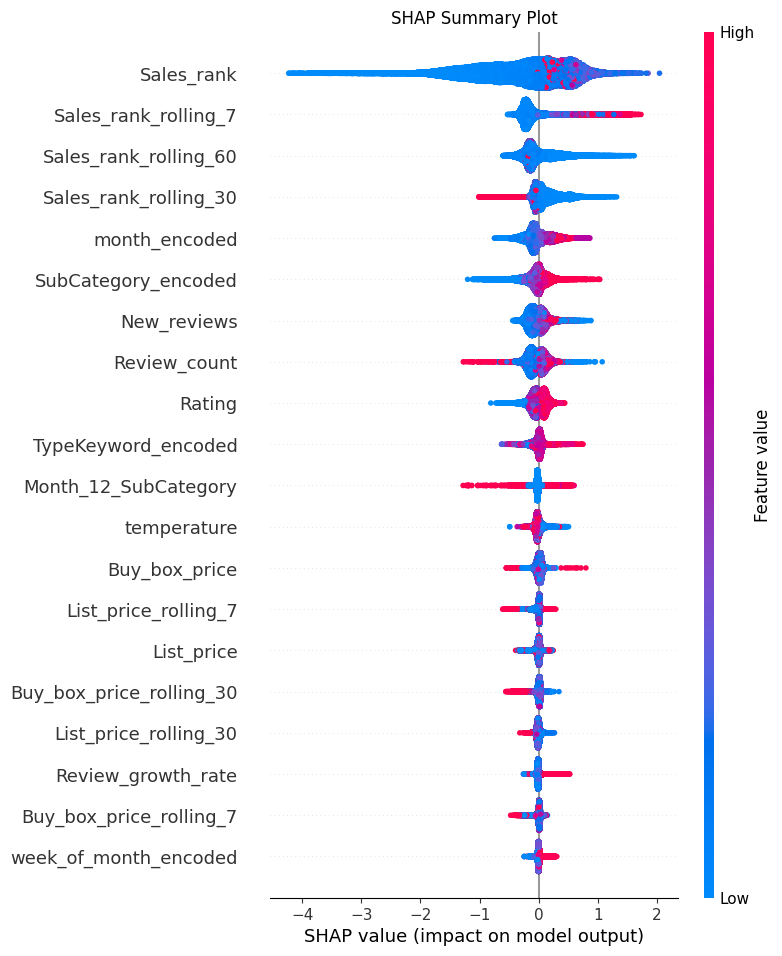

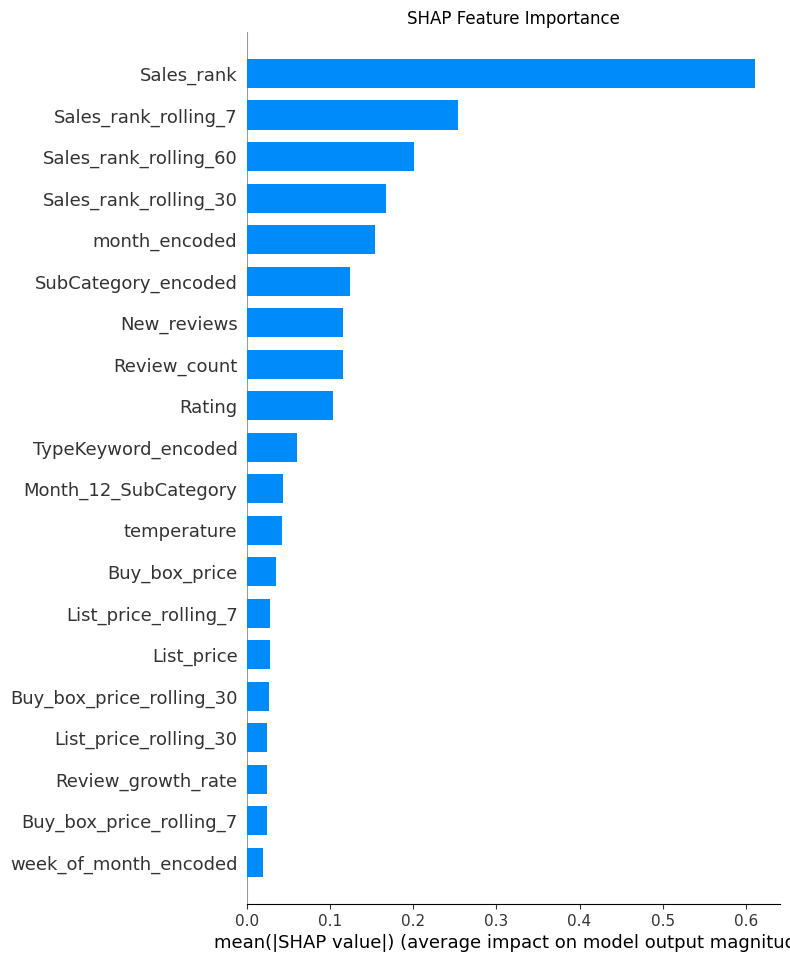


✅ XGBoost Model (with Cross Validation) & SHAP Analysis Completed!


In [ ]:
 import shap
 import xgboost as xgb
 import numpy as np
 import pandas as pd
 import matplotlib.pyplot as plt
 from sklearn.model_selection import train_test_split, StratifiedKFold
 from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# 🎯 1️⃣ データ準備
global features
X = df_updated_scaled[features]
y = df_updated_scaled["Go_viral"]

# 🎯 2️⃣ 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🎯 3️⃣ クロスバリデーション設定
cv_folds = 5
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# XGBoost パラメータ設定
# xgb_params = {
#     "objective": "binary:logistic",
#     "eval_metric": "logloss",
#     "random_state": 42,
#     "scale_pos_weight": len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))  # クラス不均衡対応
# }

xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "random_state": 42,
    "scale_pos_weight": len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1])),  # クラス不均衡対応
    "colsample_bytree": 1.0,
    "learning_rate": 0.1,
    "max_depth": 7,
    "n_estimators": 150,
    "subsample": 0.8
}

# 🎯 4️⃣ クロスバリデーション実施
cv_results = xgb.cv(
    params=xgb_params,
    dtrain=xgb.DMatrix(X_train, label=y_train),
    num_boost_round=100,  # 最大100回のブースティング
    folds=cv,
    early_stopping_rounds=10,  # 10回連続で改善しなければストップ
    metrics=["logloss", "auc"],  # ログ損失とAUCを記録
    as_pandas=True,
    seed=42
)


# 🎯 5️⃣ ベストなブーストラウンドを取得して再学習
best_num_boost_round = len(cv_results)
xgb_cv5_model = xgb.train(
    params=xgb_params,
    dtrain=xgb.DMatrix(X_train, label=y_train),
    num_boost_round=best_num_boost_round
)

# 🎯 6️⃣ 予測と評価
y_pred_proba = xgb_cv5_model.predict(xgb.DMatrix(X_test))  # 確率値
y_pred = (y_pred_proba > 0.6).astype(int)  # 閾値 0.5 で分類

# 評価指標の計算
xgb_cv5_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred_proba)
}

# 結果表示
print("\n🎯 XGBoost Model Performance (with Cross Validation):")
for metric, value in xgb_cv5_metrics.items():
    print(f"{metric}: {value:.4f}")

# 🎯 7️⃣ AUC曲線をプロット
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {xgb_cv5_metrics['AUC']:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.savefig("xgb_auc_curve.png")  # AUCプロットを保存
plt.show()

# 🎯 8️⃣ SHAP解析
explainer = shap.TreeExplainer(xgb_cv5_model)
shap_values = explainer.shap_values(X_test)

# 🎯 SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot")
plt.savefig("shap_summary_plot.png", bbox_inches="tight")  # 画像保存
plt.show()

# 🎯 SHAP Bar Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.savefig("shap_bar_plot.png", bbox_inches="tight")  # 画像保存
plt.show()

print("\n✅ XGBoost Model (with Cross Validation) & SHAP Analysis Completed!")


# 5-4 Analysis 4: XGBoost: Cross-Validation & Grid Search
- Cross Validation: K = 5
- Parameter tuning: Grid Search

Fitting 5 folds for each of 108 candidates, totalling 540 fits

✅ Best Parameters Found by GridSearchCV:
{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 150, 'subsample': 0.8}

🎯 XGBoost Model Performance (Optimized with GridSearchCV):
accuracy: 0.8514
precision: 0.8445
recall: 0.1687
f1: 0.2812
AUC: 0.8519


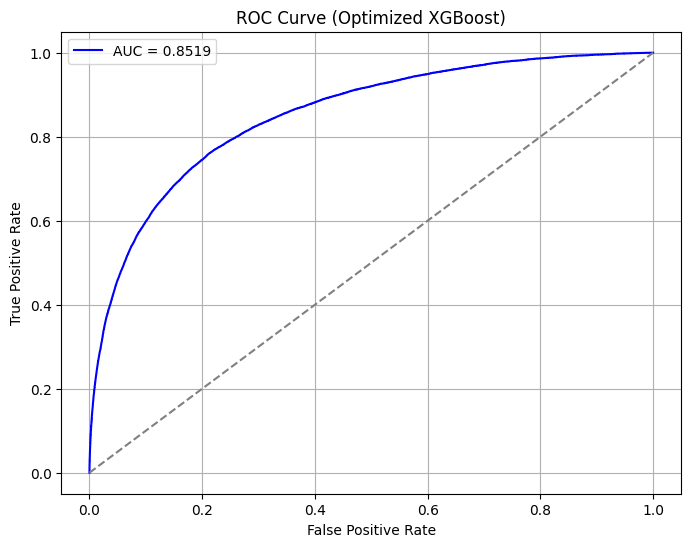

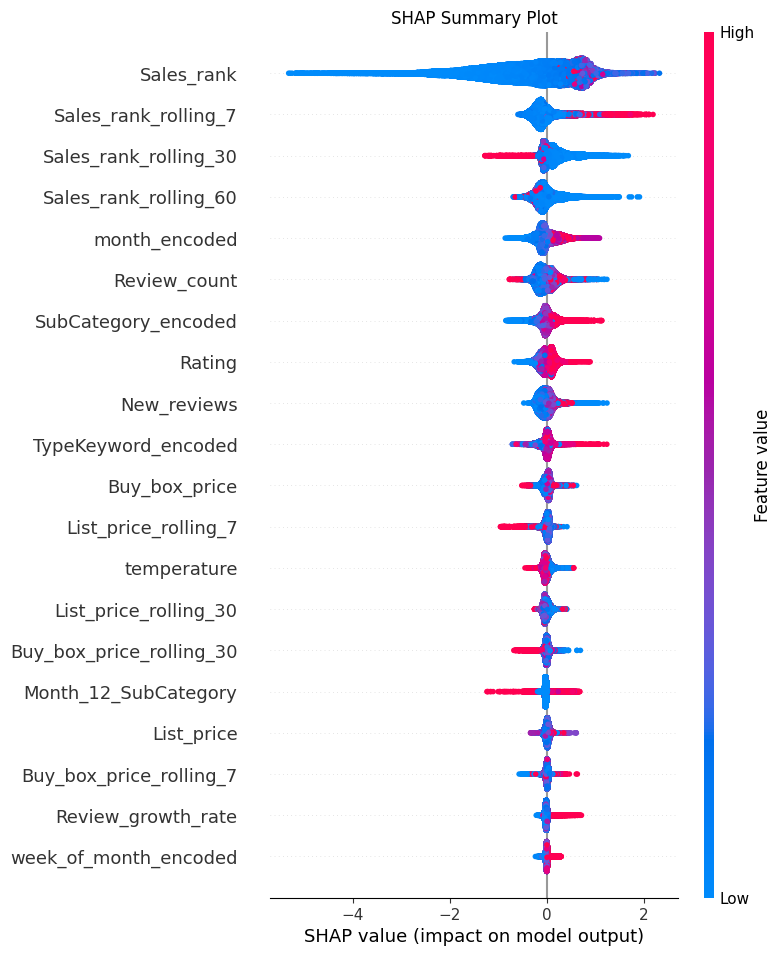

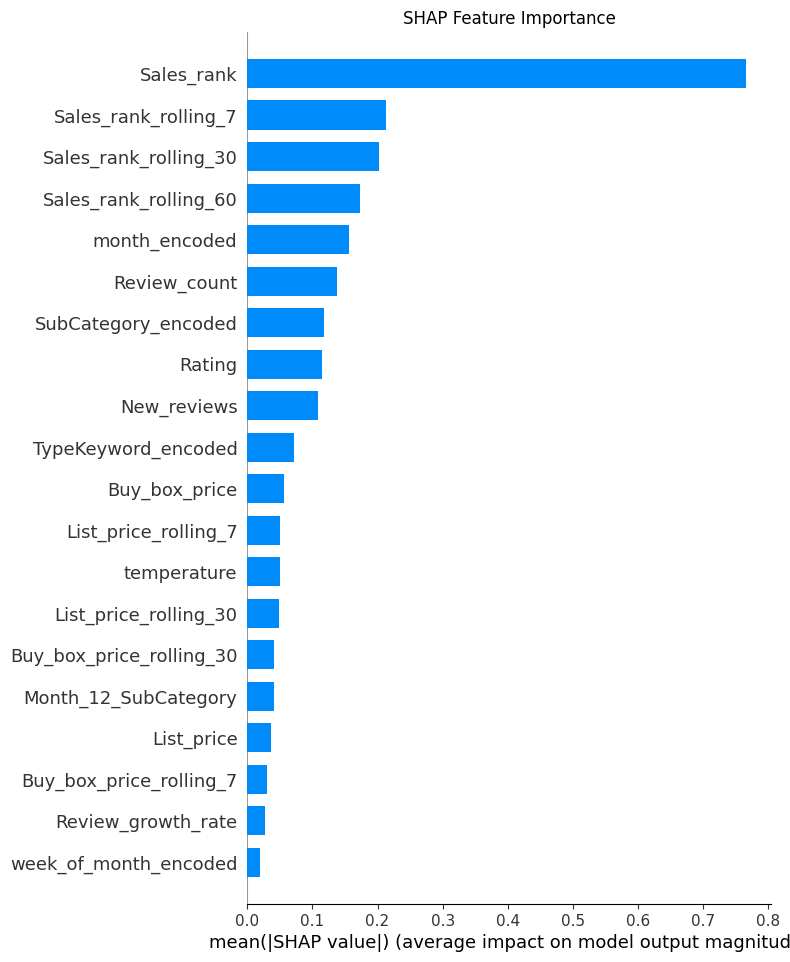


✅ Optimized XGBoost Model (with GridSearchCV) & SHAP Analysis Completed!


In [ ]:
# import shap
# import xgboost as xgb
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# 🎯 1️⃣ データ準備
global features
X = df_updated_scaled[features]
y = df_updated_scaled["Go_viral"]

# 🎯 2️⃣ 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 🎯 3️⃣ クロスバリデーション設定
cv_folds = 5
cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

# 🎯 4️⃣ グリッドサーチ用パラメータ
param_grid = {
    "max_depth": [3, 5, 7],               # 決定木の深さ
    "learning_rate": [0.01, 0.05, 0.1],   # 学習率
    "n_estimators": [50, 100, 150],       # 木の数
    "subsample": [0.8, 1.0],              # サブサンプル率
    "colsample_bytree": [0.8, 1.0]        # 特徴量のサブサンプル率
}

# 🎯 5️⃣ XGBoostモデル & グリッドサーチ
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    scale_pos_weight=len(y_train[y_train == 0]) / max(1, len(y_train[y_train == 1]))  # クラス不均衡対応
)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# 🎯 6️⃣ グリッドサーチの実行
grid_search.fit(X_train, y_train)

# 🎯 7️⃣ 最適パラメータの取得
best_params = grid_search.best_params_
print("\n✅ Best Parameters Found by GridSearchCV:")
print(best_params)

# 🎯 8️⃣ 最適パラメータで XGBoost を再学習
best_xgb_model = xgb.XGBClassifier(**best_params, eval_metric="logloss", random_state=42)
best_xgb_model.fit(X_train, y_train)

# 🎯 9️⃣ 予測と評価
y_pred_proba = best_xgb_model.predict_proba(X_test)[:, 1]  # クラス1の確率
y_pred = (y_pred_proba > 0.6).astype(int)  # Setting Threshold

# 評価指標の計算
xgb_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred),
    "recall": recall_score(y_test, y_pred),
    "f1": f1_score(y_test, y_pred),
    "AUC": roc_auc_score(y_test, y_pred_proba)
}

# 結果表示
print("\n🎯 XGBoost Model Performance (Optimized with GridSearchCV):")
for metric, value in xgb_metrics.items():
    print(f"{metric}: {value:.4f}")

# 🎯 1️⃣0️⃣ AUC曲線をプロット
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {xgb_metrics['AUC']:.4f}", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Optimized XGBoost)")
plt.legend()
plt.grid()
plt.savefig("optimized_xgb_auc_curve.png")  # AUCプロットを保存
plt.show()

# 🎯 1️⃣1️⃣ SHAP解析
explainer = shap.TreeExplainer(best_xgb_model)
shap_values = explainer.shap_values(X_test)

# 🎯 SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title("SHAP Summary Plot")
plt.savefig("optimized_shap_summary_plot.png", bbox_inches="tight")  # 画像保存
plt.show()

# 🎯 SHAP Bar Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.savefig("optimized_shap_bar_plot.png", bbox_inches="tight")  # 画像保存
plt.show()

print("\n✅ Optimized XGBoost Model (with GridSearchCV) & SHAP Analysis Completed!")


# 6 Results matrix
- Accuracy / Precision / Recall / F1 score / AUC   

Final model: XGBoost w/ CV and Grid Search optimization

In [ ]:
# すべての評価指標をDataFrameに変換
evaluation_df = pd.DataFrame({
    "Logistic Regression": lr_metrics,
    "Random Forest": rf_metrics,
    "XGBoost": xgb_cv5_metrics,
    "XGBoost with GridSearch(★)": xgb_metrics
}).T

# 欠損値を埋める
evaluation_df = evaluation_df.fillna("-")

#print(f"[Baby Product]\nRecord: {len(df_updated_scaled)} (last 4 years / 224 SKU)")
print(f"[Pet Product]\nRecord: {len(df_updated_scaled)} (last 3 years / 500 SKU)")
print(f"Viral ratio: {final_df['Go_viral'].mean():.2%}")
print("\nModel results: 5-fold Cross Validation")
print(evaluation_df)

[Pet Product]
Record: 473164 (last 3 years / 500 SKU)
Viral ratio: 16.76%

Model results: 5-fold Cross Validation
                            accuracy  precision    recall        f1       AUC
Logistic Regression         0.785931   0.283266  0.181371  0.221146  0.617294
Random Forest               0.830249   0.492092  0.406539  0.445243  0.786290
XGBoost                     0.848288   0.540664  0.628871  0.581441  0.865836
XGBoost with GridSearch(★)  0.856160   0.865041  0.167749  0.281006  0.864997


# 7 Predict future viral products using The Last 60 days data

In [ ]:
# 1. df_updated_scaledから直近60日のデータを抽出（インデックスを保持）
latest_date = pd.to_datetime(df_updated_scaled['timestamp']).max()
start_date = latest_date - timedelta(days=60)
recent_data = df_updated_scaled[pd.to_datetime(df_updated_scaled['timestamp']) >= start_date]

# 2. 特徴量とターゲットを分離
X_recent = recent_data[features]
y_recent = recent_data["Go_viral"]

# 3. 予測の実行
y_pred_proba = best_xgb_model.predict_proba(X_recent)[:, 1]
y_pred = (y_pred_proba > 0.6).astype(int)

# 4. 予測結果をデータフレームとして保存（元のインデックスを使用）
prediction_results = pd.DataFrame({
    'predicted_label': y_pred,
    'prediction_probability': y_pred_proba
}, index=recent_data.index)

# 5. final_dfから該当の期間のレコードを抽出（インデックスを保持）
final_df_recent = final_df[pd.to_datetime(final_df['timestamp']) >= start_date].copy()

# 6. インデックスで結合
final_df_recent = final_df_recent.join(prediction_results)
final_df_recent = final_df_recent[['timestamp', 'ASIN','Buy_box_price','Sales_rank','SubCategory', 'TypeKeyword','Go_viral','predicted_label', 'prediction_probability']]
print("\n=== 結合結果の確認 ===")
print("元のインデックスが保持されているか確認:")
print(final_df_recent[['timestamp', 'ASIN','Buy_box_price','Sales_rank','Go_viral','predicted_label', 'prediction_probability']].head())


=== 結合結果の確認 ===
元のインデックスが保持されているか確認:
                      timestamp        ASIN  Buy_box_price  Sales_rank  \
1395  2025-02-14 00:00:00-05:00  B0011XOXG2          42.99     4865.25   
1396  2025-02-15 00:00:00-05:00  B0011XOXG2          42.99     4865.25   
1397  2025-02-16 00:00:00-05:00  B0011XOXG2          42.99     4865.25   
1398  2025-02-17 00:00:00-05:00  B0011XOXG2          42.99     4865.25   
1399  2025-02-18 00:00:00-05:00  B0011XOXG2          42.99     4865.25   

      Go_viral  predicted_label  prediction_probability  
1395         0                0                0.298899  
1396         0                0                0.298899  
1397         0                0                0.285099  
1398         0                0                0.285099  
1399         1                0                0.298899  


In [ ]:
output_filename = f'final_df_predictions_recent60days.xlsx'
final_df_recent.to_excel(output_filename, index=True)

# 8-1 Distribution of Sales rank Before & After among detected products

In [ ]:
# 🎯 1️⃣ スケーリングを元に戻す
df_original_values = df_updated.copy()  # 元データのコピー

# `features` のスケーリングを戻す
#df_original_values[features] = scaler.inverse_transform(df_updated_scaled[features])

# 🎯 2️⃣ Viralと予測されたレコードの元のSales Rankと予測後のSales Rankを取得
viral_indices = X_test[y_pred == 1].index  # 予測でViralとされたレコードのインデックス

# 元のスケールに戻したデータを参照
df_viral_sales = df_original_values.loc[viral_indices, ["ASIN", "Sales_rank", "Sales_rank_change_30d","Buy_box_price"]].copy()

# 🎯 3️⃣ 未来のSales Rankを計算
df_viral_sales["Future_Sales_Rank"] = df_viral_sales["Sales_rank"] * (1 + df_viral_sales["Sales_rank_change_30d"] / 100)

# 🎯 4️⃣ 確認
print("\n✅ 元のスケールに戻した Sales Rank:")
print(df_viral_sales.head(500))



✅ 元のスケールに戻した Sales Rank:
              ASIN  Sales_rank  Sales_rank_change_30d  Buy_box_price  \
242409  B07MWYH7SW     2060.00             -83.446602          12.12   
149046  B01H3OA816      760.00             -48.421053          15.98   
260791  B0BCX7SQG6     2030.00             -81.131619          14.99   
143216  B09NW91XWZ     1172.75             -99.406222          15.47   
445711  B003O7ZON4      311.00             -54.340836          41.00   
...            ...         ...                    ...            ...   
197836  B075LTG2Q5      395.50             -66.968744          12.94   
448832  B079T3KSYL     5343.00             -55.380872          20.85   
140502  B0BW22VCNW      649.00             -99.554035           8.99   
294558  B07121B839       85.00             -45.882353          28.97   
413203  B06XJY5H5S     1841.00             -27.376426          24.99   

        Future_Sales_Rank  
242409         341.000000  
149046         392.000000  
260791         383.028143

# 8-2 Density distribution of sales rank Before & After
- Sales Rank before & after among detected products as Go_Viral

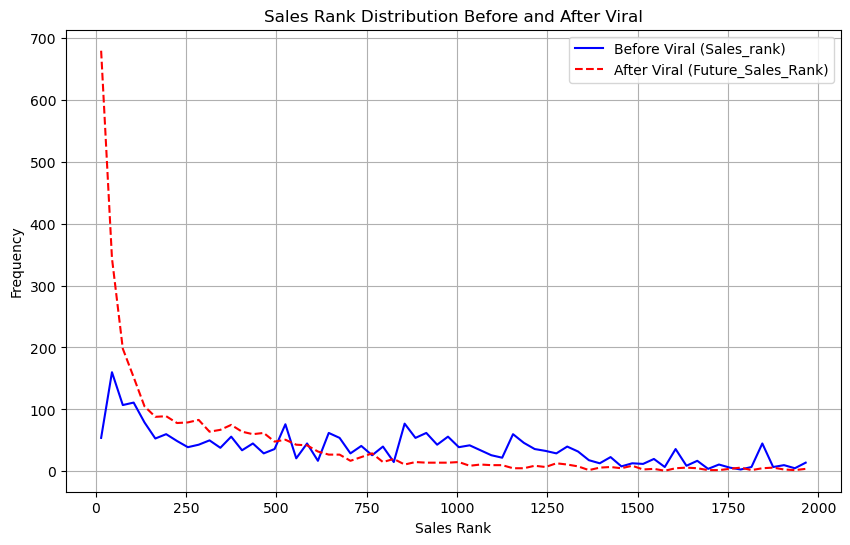

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# 30区切りのbinを作成
bins = np.arange(0, 2000, 30)

# 各binで度数をカウント
sales_rank_hist, _ = np.histogram(df_viral_sales["Sales_rank"], bins=bins)
future_sales_rank_hist, _ = np.histogram(df_viral_sales["Future_Sales_Rank"], bins=bins)

# プロット用のx軸 (各binの中心を使用)
bin_centers = (bins[:-1] + bins[1:]) / 2

# グラフの作成
plt.figure(figsize=(10, 6))
plt.plot(bin_centers, sales_rank_hist, label="Before Viral (Sales_rank)", color="blue", linestyle="-")
plt.plot(bin_centers, future_sales_rank_hist, label="After Viral (Future_Sales_Rank)", color="red", linestyle="--")

# ラベルとタイトル
plt.xlabel("Sales Rank")
plt.ylabel("Frequency")
plt.title("Sales Rank Distribution Before and After Viral")
plt.legend()
plt.grid(True)

# グラフを表示
plt.show()


# 9-1 Monetaly Calculation: Wkly sales units calculation using formula from the study
The research paper gives a way to turn Amazon’s sales rank into actual sales numbers for products in the "Pet Supplies" category.
https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3728281  

For "Pet Supplies," the formula to find the weekly sales (in units per week) based on the sales rank is:  
Weekly Sales=EXP((LN(rank-1)-10.72)/-0.516)

This formula works best for mid-rank products around salesRank:1000.  
Thus, use products ranked between 500 and 1500.  

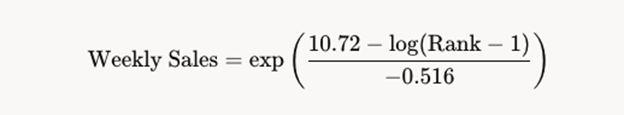

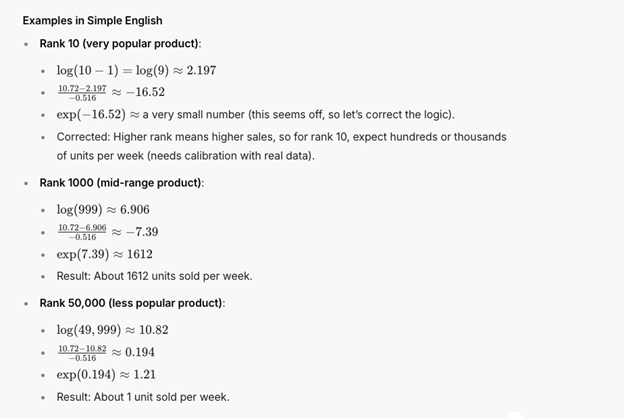



In [ ]:
import numpy as np
import pandas as pd

# 数式を適用する関数
def calculate_weekly_sales(rank):
    #return np.exp((10.72 - np.log(rank - 1)) / -0.516)
    return np.exp((np.log(rank - 1) - 10.72) / -0.516)

# Sales Rank の Before, After が 500 - 1500 の範囲のデータを抽出
df_filtered = df_viral_sales[(df_viral_sales['Sales_rank'].between(500, 1500)) &
                             (df_viral_sales['Future_Sales_Rank'].between(500, 1500))].copy()

# 数式を適用して Weekly Sales を計算
df_filtered['Weekly_Sales_Before'] = calculate_weekly_sales(df_filtered['Sales_rank'])
df_filtered['Weekly_Sales_After'] = calculate_weekly_sales(df_filtered['Future_Sales_Rank'])
df_filtered['Expected_increase'] = df_filtered['Weekly_Sales_After'] - df_filtered['Weekly_Sales_Before']

# 必要なカラムのみを保持
df_result = df_filtered[['ASIN', 'Sales_rank', 'Future_Sales_Rank', 'Weekly_Sales_Before', 'Weekly_Sales_After','Expected_increase']]

# 🎯 Expected_increase の平均を計算
expected_increase_mean = df_result['Expected_increase'].mean()

# 🎯 Expected_increase の正負カウント
tp_count = (df_result['Expected_increase'] > 0).sum()  # True Positive (売上が増えた)
fp_count = (df_result['Expected_increase'] <= 0).sum()  # False Positive (売上が減った)

# 結果表示
print(df_result.head(5))
print("\n=== Analysis Summary ===\n-Mid-rank Products (rank:500-1500)")
print(f"-Records: {len(df_result)}, Unique ASIN: {len(df_result['ASIN'].unique())}")
print(f"Expected Increase units (mean): {expected_increase_mean:.2f}")
print(f"True Positive (Sales increased): {tp_count}")
print(f"False Positive (Sales decreased): {fp_count}")


              ASIN  Sales_rank  Future_Sales_Rank  Weekly_Sales_Before  \
386134  B0CGN1B9TP    1445.000         798.000000           793.158152   
312424  B09VZNSTRL     979.375         505.719188          1686.549256   
231883  B07N72XW67    1042.000        1070.686997          1495.475476   
81586   B00JOZ48KK     909.500         504.428571          1946.992036   
226005  B074YZKSH4    1194.000         561.000000          1148.340144   

        Weekly_Sales_After  Expected_increase  
386134         2509.405145        1716.246993  
312424         6082.517839        4395.968582  
231883         1418.729096         -76.746380  
81586          6112.774085        4165.782049  
226005         4972.860064        3824.519920  

=== Analysis Summary ===
-Mid-rank Products (rank:500-1500)
-Records: 299, Unique ASIN: 125
Expected Increase units (mean): 1619.60
True Positive (Sales increased): 235
False Positive (Sales decreased): 64


# 9-2 Confusion Matrix

In [ ]:
import numpy as np
import pandas as pd

# 数式を適用する関数（Weekly Sales を計算）
def calculate_weekly_sales(rank):
    return np.exp((np.log(rank - 1) - 10.72) / -0.516)

# 🔹 データをフィルタリング（Sales Rank: 400〜3000）
df_filtered = df_viral_sales[
    (df_viral_sales['Sales_rank'].between(500, 1500)) &
    (df_viral_sales['Future_Sales_Rank'].between(500, 1500))
].copy()

# 🔹 Weekly Sales を計算
df_filtered['Weekly_Sales_Before'] = calculate_weekly_sales(df_filtered['Sales_rank'])
df_filtered['Weekly_Sales_After'] = calculate_weekly_sales(df_filtered['Future_Sales_Rank'])
df_filtered['Expected_increase'] = df_filtered['Weekly_Sales_After'] - df_filtered['Weekly_Sales_Before']

# 🔹 BuyBox 価格（スケール済 or 元データから復元）を追加しておくこと！
# ここでは既に含まれていると仮定 → 例: df_filtered["Buy_box_price"]

# 🔹 金額インパクトの計算
df_filtered["Expected_Revenue_Impact"] = df_filtered["Expected_increase"] * df_filtered["Buy_box_price"]

# 🔹 TP / FP 判定（Expected_increase の正負で判断）
tp_df = df_filtered[df_filtered["Expected_increase"] > 0]
fp_df = df_filtered[df_filtered["Expected_increase"] <= 0]

# 🔹 サマリー計算
tp_revenue = tp_df["Expected_Revenue_Impact"].sum()
fp_loss = -fp_df["Expected_Revenue_Impact"].sum()  # 損失なので符号反転


###
# 🔹 追加: ユニークASIN数、レコード数、平均Expected Revenue
total_records = len(df_filtered)
unique_asins = df_filtered['ASIN'].nunique()
expected_revenue_mean = df_filtered["Expected_Revenue_Impact"].mean()
precision_mid = tp_count / (tp_count + fp_count)
FP_rate = 1 - precision_mid

# 🔹 結果表示
print("=== Confusion Matrix with Sales Impact (Focusing on Precision) ===")
print("[Pet Products]")
print(f"Detected Records among Mid-rank Products (rank:500-1500)")
print(f"-Records: {total_records}")
print(f"-Unique ASINs: {unique_asins}")

print("\n■ Monetary calculation using the Formula")
print(f"\nTrue Positive (TP) - Sales Increased: {len(tp_df)} records (Precision: {precision_mid:.1%}))")
print(f"  ➤ Expected Increase: ${tp_revenue:,.0f}")
print(f"False Positive (FP) - Sales Decreased: {len(fp_df)} records (FP ratio: {FP_rate:.1%})")
print(f"  ➤ Expected Loss: ${fp_loss:,.0f}")


# ✨ 表示
print("\n=== 💰 Expected Weekly Sales Increase (rank:500-1500) ===")
print(f"Expected Weekly Sales Impact: ${expected_revenue_mean:,.0f}")
print(f"Expected Weekly Units Increase: {expected_increase_mean:.0f}")


=== Confusion Matrix with Sales Impact (Focusing on Precision) ===
[Pet Products]
Detected Records among Mid-rank Products (rank:500-1500)
-Records: 299
-Unique ASINs: 125

■ Monetary calculation using the Formula

True Positive (TP) - Sales Increased: 235records (Precision: 78.6%))
  ➤ Expected Increase: $15,456,582
False Positive (FP) - Sales Decreased: 64records (FP ratio: 21.4%)
  ➤ Expected Loss: $2,135,178

=== 💰 Expected Weekly Sales Increase (rank:500-1500) ===
Expected Weekly Sales Impact: $44,553
Expected Weekly Units Increase: 1620


# 10-1 Causal Analysis with Propensity Score Matching
- Measure the effect of the isSNS flag, which tells us if a product website is eligible for Subscribe & Save.  

- This feature appeared in about 72.6% of products, so it’s widely adopted.

- To control for bias, used logistic regression to estimate propensity scores, and matched treated and untreated products using K-nearest neighbors with K=1."

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors

# 🎯 1️⃣ 処置変数（isSNS）と目的変数（Go_viral）、特徴量
df_updated_scaled['isSNS'] = (df_updated_scaled["isSNS"] > 0).astype(int)
treatment_col = 'isSNS'
outcome_col = 'Go_viral'
features_psm = ['SubCategory_encoded', 'TypeKeyword_encoded','Sales_rank', 'List_price', 'Buy_box_price', 'Review_count', 'Rating',
                'month_encoded','week_of_month_encoded', 'temperature']
X = df_updated_scaled[features_psm]  # isSNSとGo_viral除外
treatment = df_updated_scaled[treatment_col]
outcome = df_updated_scaled[outcome_col]

# 🎯 2️⃣ Propensity Score の推定
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, treatment)
propensity_scores = ps_model.predict_proba(X)[:, 1]
df_updated_scaled['propensity_score'] = propensity_scores

# 🎯 3️⃣ 介入群と非介入群に分割
treated = df_updated_scaled[df_updated_scaled[treatment_col] == 1].copy()
control = df_updated_scaled[df_updated_scaled[treatment_col] == 0].copy()

# 🎯 4️⃣ 最近傍マッチング（1:1）
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()].copy()
matched_control.index = treated.index  # indexを揃える

# 🎯 5️⃣ マッチ後のデータ作成
matched_df = treated.copy()
matched_df['control_outcome'] = matched_control[outcome_col]
matched_df['treatment_outcome'] = treated[outcome_col]

# 🎯 6️⃣ ATT（平均処置効果）を計算
matched_df['effect'] = matched_df['treatment_outcome'] - matched_df['control_outcome']
ATT = matched_df['effect'].mean()

# 🎯 7️⃣ 結果表示
#print("[Causal Analysis with PSM: Baby Product]")
print("[Causal Analysis with PSM: Pet Products]")
print("Causal Effect Estimation via Propensity Score Matching (Treatment = isSNS flag)")
print("- PSM Method: Logit & K-NN (K=1)")
print(f"- isSNS ratio: {df_updated_scaled['isSNS'].mean():.1%}")
print("\nOutcome means:")
print(f"- Treated group mean: {matched_df['treatment_outcome'].mean():.4f}")
print(f"- Matched control group mean: {matched_df['control_outcome'].mean():.4f}")
print(f"- ATT (Average Treatment effect on the Treated): {ATT:.4f}")


[Causal Analysis with PSM: Pet Products]
Causal Effect Estimation via Propensity Score Matching (Treatment = isSNS flag)
- PSM Method: Logit & K-NN (K=1)
- isSNS ratio: 72.6%

Outcome means:
- Treated group mean: 0.1658
- Matched control group mean: 0.1828
- ATT (Average Treatment effect on the Treated): -0.0171


## Causal Analysis Result:
The ATT or Average Treatment Effect score was -0.017, meaning products with the isSNS flag—those eligible for Subscribe & Save—actually did a bit worse in terms of going viral.  
The treated group had a slightly lower outcome than the control group, so we can say that isSNS doesn’t really help boost virality."

# 10-2 Propensity Score Kernel Density

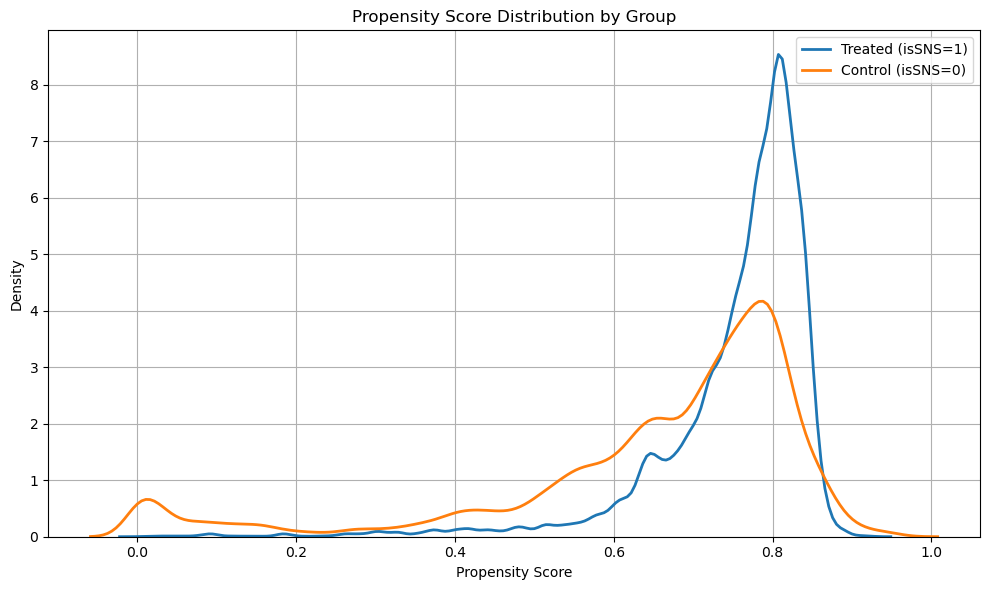

In [ ]:
# 🔹 グループ分け
treated_scores = df_updated_scaled[df_updated_scaled['isSNS'] == 1]['propensity_score']
control_scores = df_updated_scaled[df_updated_scaled['isSNS'] == 0]['propensity_score']

# 🔹 図の描画
plt.figure(figsize=(10, 6))
sns.kdeplot(treated_scores, label="Treated (isSNS=1)", linewidth=2)
sns.kdeplot(control_scores, label="Control (isSNS=0)", linewidth=2)

# 🔹 グラフの装飾
plt.title("Propensity Score Distribution by Group")
plt.xlabel("Propensity Score")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Propensity Score Matching w/ Caliper (Taking too much time,,)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

# 🎯 1️⃣ 処置変数（isSNS）と目的変数（Go_viral）、特徴量
df_updated_scaled['isSNS'] = (df_updated_scaled["isSNS"] > 0).astype(int)
treatment_col = 'isSNS'
outcome_col = 'Go_viral'
features_psm = ['SubCategory_encoded', 'TypeKeyword_encoded','Sales_rank', 'List_price', 'Buy_box_price',
                'Review_count', 'Rating', 'month_encoded','week_of_month_encoded', 'temperature']
X = df_updated_scaled[features_psm]
treatment = df_updated_scaled[treatment_col]
outcome = df_updated_scaled[outcome_col]

# 🎯 2️⃣ 傾向スコアの推定
ps_model = LogisticRegression(max_iter=1000)
ps_model.fit(X, treatment)
propensity_scores = ps_model.predict_proba(X)[:, 1]
df_updated_scaled['propensity_score'] = propensity_scores

# 🎯 3️⃣ 介入群と非介入群に分割
treated = df_updated_scaled[df_updated_scaled[treatment_col] == 1].copy()
control = df_updated_scaled[df_updated_scaled[treatment_col] == 0].copy()

# 🎯 4️⃣ Caliper 設定
caliper = 0.01
matched_indices = []
matched_controls = []

available_control = control.copy()

# 🎯 5️⃣ Caliper マッチングループ（1:1マッチ without replacement）
for idx, row in treated.iterrows():
    pscore = row['propensity_score']
    candidates = available_control[np.abs(available_control['propensity_score'] - pscore) <= caliper]

    if not candidates.empty:
        best_match_idx = (np.abs(candidates['propensity_score'] - pscore)).idxmin()
        matched_indices.append((idx, best_match_idx))
        matched_controls.append(available_control.loc[best_match_idx])
        available_control = available_control.drop(best_match_idx)

# 🎯 6️⃣ マッチしたデータの DataFrame を作成
matched_df = treated.loc[[i[0] for i in matched_indices]].copy()
matched_control_df = pd.DataFrame(matched_controls)
matched_control_df.index = matched_df.index  # index を合わせる

matched_df['control_outcome'] = matched_control_df[outcome_col]
matched_df['treatment_outcome'] = matched_df[outcome_col]
matched_df['effect'] = matched_df['treatment_outcome'] - matched_df['control_outcome']

# 🎯 7️⃣ ATT を計算
ATT = matched_df['effect'].mean()

# 🎯 8️⃣ 結果表示
print("🎯 Caliper Matching Causal Effect Estimation (±0.01 caliper)")
print(f"Matched sample size: {len(matched_df)}")
print(f"Average Treatment Effect on the Treated (ATT): {ATT:.4f}\n")
print("Outcome means:")
print(f"- Treated group mean: {matched_df['treatment_outcome'].mean():.4f}")
print(f"- Matched control group mean: {matched_df['control_outcome'].mean():.4f}")


# Model Usability
- Confirmed that the model works well also the other category (e.g.,Baby Product)

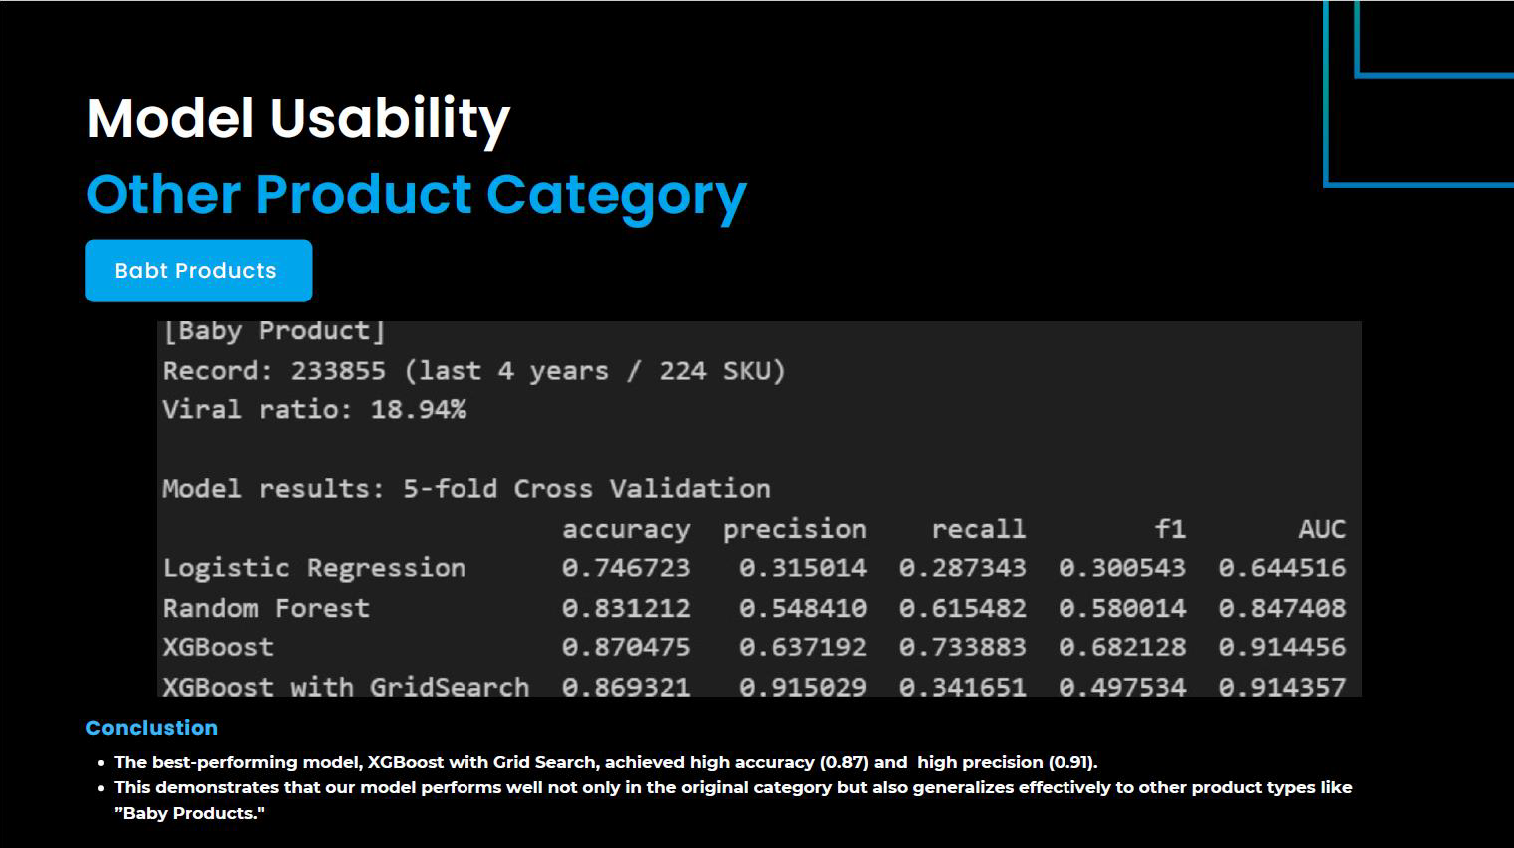